# **Clinical-Trial Survival Analysis for Treatment Efficacy**

This project helps:

* Understand how to work with "time-to-event" date(eg., time until death, recovery or disease return).
* Use visual tools like survival curves to compare treatments.
* Perform statistical tests to check if one treatment is better than another.
---

This project helps learn how to:
* Work with real, messy clinical data
* Think like a researcher:
* Apply statistical thinking to life-saving decisions.
---

Real-World Impact

Hospitals, pharmaceutical companies and public health researchers use these exact methods to:
* Approve or reject new drugs.
* Personalize treatment plans.
* Improve patient outcomes and safety.

In [42]:
!pip install lifelines --quiet
# lifelines is a special library used for survival analysis -a type of analysis used in medical research to study how long something lasts
# (like how long patient survive, or how long until a disease returns.)

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import seaborn as sns

In [44]:
df = pd.read_csv('https://samatrix-data.s3.ap-south-1.amazonaws.com/Statistics-Project/veteran.csv')

In [45]:
df.head()

,ID,TIME,Y,trt,celltype,karno,diagtime,age,priortherapy
0,1,0,0,standard,squamous,60,7,69,no
1,1,72,1,standard,squamous,60,7,69,no
2,2,0,0,standard,squamous,70,5,64,yes
3,2,411,1,standard,squamous,70,5,64,yes
4,3,0,0,standard,squamous,60,3,38,no


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            274 non-null    int64 
 1   TIME          274 non-null    int64 
 2   Y             274 non-null    int64 
 3   trt           274 non-null    object
 4   celltype      274 non-null    object
 5   karno         274 non-null    int64 
 6   diagtime      274 non-null    int64 
 7   age           274 non-null    int64 
 8   priortherapy  274 non-null    object
dtypes: int64(6), object(3)
memory usage: 19.4+ KB


# **What is the kaplan-Meier Method?**

The Kaplan-Meier estimator is a simple and powerful way to answer the question:

> "How likely is something to survive (or continue) over time?"


---

**What the Kaplan-Meier Curve shows:**
* The curve starts at 100% survival (everyone is alive at the begining).
* As time passes, the curve drops when patients die.
* If a patient drops out of the study (censored), they don't affect the drop but they are considered in the "at risk" group.

Terms:
* Survival: Not dying/ still working/ still active.
* Event: The thing you're tracking(e.g., death, failures, quiting)
* Censoring: You lost track of someone before the event happened.




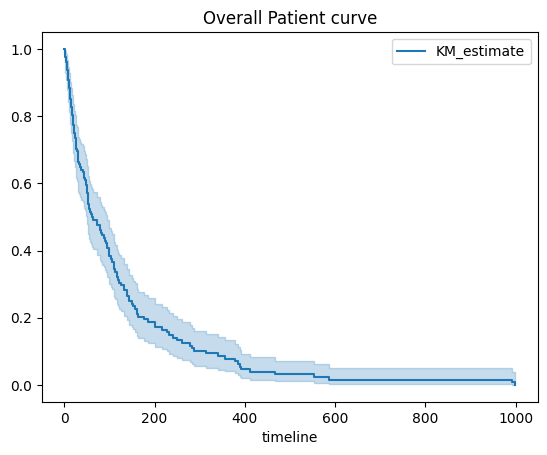

In [47]:
kmf=KaplanMeierFitter()
#separate your event(y=1 or y=0)
df_event=df[df['Y']==1]

#for overall patient curve
kmf.fit(durations=df_event['TIME'],event_observed=df_event['Y'])
kmf.plot_survival_function()
plt.title('Overall Patient curve')
plt.show()


This plot shows the overall survival of all patients.

Here;

We observed that the curve starts at 1.0 (100%) because everyone is alive at the begining. The curve drops in steps -each drop represents a patient dying. The flatter parts of the curve means that no death happend during that time.
The curve continues dropping as more patients die over time. Around time = 400-500, the curve levels off near zero, meaning very few patients are still surviving after that time.

The Blue shaded area around the curve is confidence interval - it shows the uncertainty in the estimate. A wider shaded area means more uncertainty (usually due to fewer patients left at that time). A narrow shaded area means more confidence in the survival estimate.

---

**Real-World Interpretation**

* This graph shows that most patients die within the first few hundered days after starting the treatment.
* Only a very small number survive beyond ~400-500 days.
* the steepness of the curve in the begining means the risk of death is the highest early on.

---
**Summary**

Steep drop: Many people died quickly

Flat area: No one died in that time range

Shaded area: How uncertain we are about the curve

Curve ends near 0: Almost everyone died by that time.

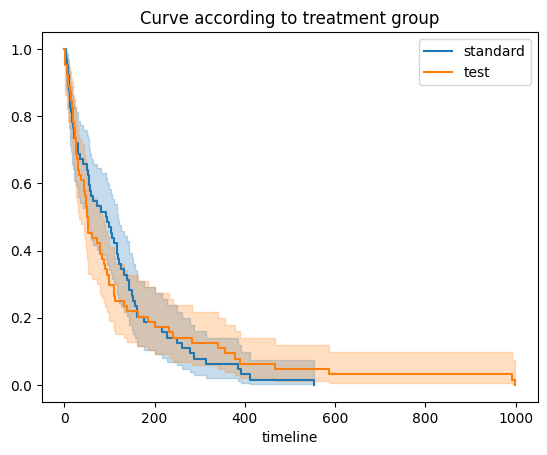

In [48]:
# Curve according to treatment group
for trt_group in df_event['trt'].unique():
  mask = df_event['trt']==trt_group   # filters data for just one treatment group at a time.
  kmf.fit(df_event[mask]['TIME'],df_event[mask]['Y'], label=str(trt_group))     # fits KM model to only that treatment group.
  kmf.plot_survival_function()
plt.title('Curve according to treatment group')
plt.show()

This plot shows the separate curve for each treatment group(e.g, Standard vs test) to see which one performs better over time. This graph compares how long patients survive under two different treatment types: "Standard" and "Test".

---

The Blue line shows patients who received the standard treatment.

The Orange line shows patients who received the test (new) treatment.

The shaded regions shows the confidence interval showing uncertainty around each survival estimate.

---
**Explanation**

Both curves start at 1.0 (100%). All patients are alive at the beginning.

Curves drop over time

* Every drop means a group of patients died at that time.

* The steeper the drop, the more deaths in that time range.

Test vs Standard

* In the early days (~0-200), test and standard treatments have similar steep drops, but the test group (orange) seems to drop faster initially, meaning fewer patients survive early on.

* Around 200-400 days, both curves flatten, but the test group eventually stays slightly above the standard group, suggesting slightly better long-term survival for test treatment in later stages - though the difference is small.

Confidence bands overlap: The difference might not be meaningful or statistically significant.

Ending near 0: Most patients in both groups eventually die.

# **Median Survival Time**

Median Survival Time answers a simple but powerful question:


> "How long did half the patients survive?"

it is the time point where the survival probability drops to 50% - meaning half the patients have experienced the event(e.g., death), and the other hapf are still alive or censored.

---

Why use the Median Instead of the Mean?

The Median is robust to these issues and gives a clear, interpretable number.



In [49]:
# Median survival time

for trt_group in df_event['trt'].unique():
  mask = df_event['trt']==trt_group
  kmf.fit(df_event[mask]['TIME'], df_event[mask]['Y'], label=str(trt_group))
  print(f"Median survival for treatment group {trt_group} is {kmf.median_survival_time_}")

Median survival for treatment group standard is 95.0
Median survival for treatment group test is 52.0


# **Log-Rank Test**

The Log-rank test helps you answer this critical question:


> "Is there a statistically significant difference in survival between two or more groups?"

It doesn't just look at who lives longer- it checks if the observed difference is real or could have happened by random chance.

---

**What it does?**

* It compares the survival curves of two or more groups
* It looks at:
 * How many people are expected to die at each time point in each group,
 * How many actually died,
 * And whether that difference is statistically significant.

 ---

We are doing a clinical trial survival analysis comparing two treatments for lung cancer:
* "Standard" treatment
* "Test" (new or experimental) treatment

---

**What Role it plays**
* Statistical Validation: It tells you the survival difference between groups is real and not due to random variation.
* Supports Conclusion: Without it, you can't confidently say one treatment is better based on survival time alone.
* Needed for reporting: It's standard in clinical trials and academic papers to prove group differences are significant.
* Complements your plots: Kaplan-Meier curves look different - but log-rank tells you if the difference is meaningful.

---

**Summary**

* Why: To check if survival differences between groups are real.

* What: Compares how many patients die over time in each group.

* When: After plotting Kaplan-Meier curves or computing median survival times.

* In your study: Confirms whether the new treatment is really better or worse than the standard.





In [50]:
# Apply log rank test

from lifelines.statistics import logrank_test
group1 = df_event[df_event['trt']== 'standard']
# patient who received standard treatment.

group2 = df_event[df_event['trt']== 'test']
# patient who received test treatment

results = logrank_test(group1['TIME'], group2['TIME'], event_observed_A =group1['Y'], event_observed_B = group2['Y'])
# Compares how long patients survived in the two groups, and test if the difference is statistically significant.

print(results.summary)
#results

#If the p-value is:
    # Less than 0.05: The difference in survival is statistically significant.
    # Greater than 0.05: There's no strong evidence of a difference.

   test_statistic        p  -log2(p)
0          0.0116  0.91423  0.129371


Here;

**test_statistic** means the test result value from the log-rank test
(A measure of how different the survival curves are)

* This is a very low test statistic, meaning the survival curves are almost the same.
* The higher this value, the bigger the difference between groups - but in your case, it's close to zero.

**p** means the p-value (the probabilitu that the difference between groups happened by random chance)

P = 0.91423
* This is the p-value, and it's very high (close to 1).
* This tells you: The difference in survival between the groups is not statistically significant.
* In most studies, if p ‹ 0.05, we consider the difference significant.
* Since 0.91423 > 0.05, we say:
"There is no strong evidence that survival differs between the two treatment groups."

**-log2(p)** means the negative log base 2 of the p-value (used to highlight how small the p-value is on a log-scale)

# **Cox Proportional Hazards Model**

To identify which factors (age, treatment, health score, etc.) influence how long a patient survives - and by how much.

It answers:
> "Which variables significantly affect a patient's risk of dying, and in what direction?"

It gives us a clear, statistical, and adjusted picture of which patient factors and treatments truly affect survival - and helps us decide what really works.

<lifelines.CoxPHFitter: fitted with 128 total observations, 0 right-censored observations>
             duration col = 'TIME'
                event col = 'Y'
      baseline estimation = breslow
   number of observations = 128
number of events observed = 128
   partial log-likelihood = -465.21
         time fit was run = 2025-06-06 07:41:34 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
ID                  0.00      1.00      0.01           -0.03            0.03                0.97                1.03
karno              -0.03      0.97      0.01           -0.05           -0.02                0.96                0.98
diagtime           -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
age                -0.01      0.99      0.01           -0.03            0.00                0.97                1.00
trt_test            0.16      1.17      1.02           -1.84            2.16                0.16                8.63
celltype_large     -0.83      0.43      0.36           -1.53           -0.14                0.22                0.87
celltype_smallcell -0.12      0.88      0.38           -0.88            0.63                0.42                1.88
celltype_squamous  -0.97      0.38      0.66           -2.27            0.33                0.10                1.38
priortherapy_yes    0.18      1.20      0.24           -0.28            0.65                0.76                1.91

                    cmp to     z      p  -log2(p)
covariate                                        
ID                    0.00  0.20   0.84      0.25
karno                 0.00 -6.08 <0.005     29.60
diagtime              0.00 -0.47   0.63      0.66
age                   0.00 -1.54   0.12      3.02
trt_test              0.00  0.16   0.88      0.19
celltype_large        0.00 -2.34   0.02      5.71
celltype_smallcell    0.00 -0.32   0.75      0.42
celltype_squamous     0.00 -1.47   0.14      2.82
priortherapy_yes      0.00  0.79   0.43      1.21
---
Concordance = 0.74
Partial AIC = 948.43
log-likelihood ratio test = 62.38 on 9 df
-log2(p) of ll-ratio test = 31.00

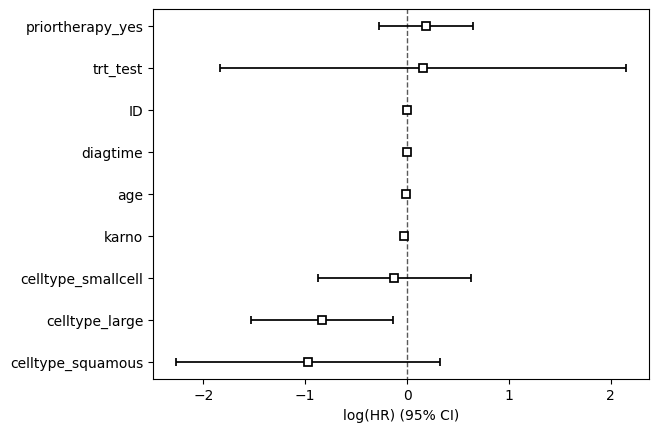

In [51]:
# CoxPH test
from lifelines import CoxPHFitter

# Prepare wide- format
df_wide = df_event.copy()
# Encoding
df_wide = pd.get_dummies(df_wide, columns=['trt', 'celltype', 'priortherapy'], drop_first=True)
# COXPH model
cph = CoxPHFitter()
cph.fit(df_wide, duration_col='TIME', event_col='Y')
cph.print_summary()
cph.plot()
plt.show()
#df_wide.head()

**Interpreting the Graph**

What It Shows:
* Each row = one variable (like age, treatment, cell type, etc.)
* Square box = estimated log(HR) (log hazard ratio)
* Horizontal line = 95% confidence interval (CI)
* Vertical dashed line at 0 = no effect

---

***How to Read It:**

* Box left of 0 (and Cl does not cross 0): Lower risk (protective effect) - significant
* Box right of 0 (and Cl does not cross 0): Higher risk (harmful effect) - significant
* Cl crosses the O line: The result is not significant - could be no real effect

# **Time-Varing Survival Analysis**

In survival analysis, the Cox model estimates how each variable (like age, treatment, or health score) affects a patient's risk of the event (like death).

But in the time-varying Cox model, these effects can change over time or across different intervals - instead of staying constant like in the regular Cox model.

**Why We Need Cox Time-Varying Coefficients**

* Standard Cox model assumes constant risk over time: Time-varying model lets risk change over time
* Some variables may affect survival only temporarily: Time varying model can detect those changes
* Patient data may include multiple time intervals: Model adjusts risk per interval
* You may want to see dynamie impact of treatment: Time-varying coefficients show how treatment effects evolve


---

You are analyzing survival among lung cancer patients and comparing two treatments (standard vs test). Each patient has:
* Two time points: one for the start (Y=0), and one for the death or censoring (Y=1).
* Some covariates (like treatment type or prior therapy) may influence risk over time or might not apply equally throughout the study.

---

**So why use time varying survival analysis here?**


* Handle multiple time points per patient: Your dataset has two rows per patient (start and death) - a perfect setup for time varying analysis.
* Model changing risk: The patient's condition (or exposure to risk) may change between those points.
* More realistic assumptions: Standard CoxPH assumes constant hazard over time - which may not hold true in your data.
* Better for advanced designs: If later you include lab results or treatment switches that vary during follow-up, this method can handle that.
* Enables interval-based modeling: Lets you create risk intervals (e.g. 0-100 days, 100-200 days) and see when risk changes most.

---

**Summary**

* CoxPH model: Estimates constant effect of each variable on survival
* Time-varying Cox model: Allows the effect (risk) to change over time
* Time-varying coefficients: Show how variables like treatment or age influence risk differently as time goes on
* In our study:  it helps analyze survival more realistically, using both time intervals and patient changes

***Why It's Valuable in Current Study**

> "Cox time-varying coefficients help us understand how the impact of treatment and other patient factors evolve over time, giving us a more accurate picture of survival risk in lung cancer patients."


In [52]:
# Time Varying survival analysis [Data Preparation]
# Step -1 seperate rows
df_start = df[df['Y']==0].copy()
df_event = df[df['Y']==1].copy()

# Step -2 merge and change column name
df_event = df_event.rename(columns={'TIME':'Stop','Y':"Event"})
df_start = df_start.rename(columns={'TIME':'Start'})

df_timevarying = pd.merge(df_start, df_event[['ID','Stop','Event']], on='ID')
#df_timevarying.head()

# one-hot encoding
df_timevarying = pd.get_dummies(df_timevarying, columns=['trt', 'celltype', 'priortherapy'], drop_first=True)
#df_timevarying.head()

# Final check
print(df_timevarying[['ID','Start','Stop','Event']].head())

# Summary

# Split data: Separates start rows and death rows
# Rename columns: Creates clear start, stop, and event labels
# Merge rows: Combines both rows into one row per patient
# Encode categories: Converts text to numbers (required for modeling)
# Print check: Confirms the data looks right before modeling

   ID  Start  Stop  Event
0   1      0    72      1
1   2      0   411      1
2   3      0   228      1
3   4      0   126      1
4   5      0   118      1


In [53]:
import numpy as np
# Check for NaNs
print("Any NaNs? ", df_timevarying.isnull().values.any())

# Check for infinite values
print("Any Infs? ", np.isinf(df_timevarying.select_dtypes(include=[np.number])).values.any())


Any NaNs?  False
Any Infs?  False


In [54]:
print(df_timevarying[df_timevarying.isnull().any(axis=1)])
print(df_timevarying[np.isinf(df_timevarying.select_dtypes(include=[np.number])).any(axis=1)])

Empty DataFrame
Columns: [ID, Start, Y, karno, diagtime, age, Stop, Event, trt_test, celltype_large, celltype_smallcell, celltype_squamous, priortherapy_yes]
Index: []
Empty DataFrame
Columns: [ID, Start, Y, karno, diagtime, age, Stop, Event, trt_test, celltype_large, celltype_smallcell, celltype_squamous, priortherapy_yes]
Index: []


<lifelines.CoxTimeVaryingFitter: fitted with 128 periods, 128 subjects, 128 events>
         event col = 'Event'
number of subjects = 128
 number of periods = 128
  number of events = 128
partial log-likelihood = -465.24
  time fit was run = 2025-06-06 07:41:41 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
karno              -0.03      0.97      0.01           -0.05           -0.02                0.96                0.98
diagtime           -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
age                -0.01      0.99      0.01           -0.03            0.00                0.97                1.00
trt_test            0.36      1.44      0.21           -0.05            0.77                0.95                2.17
celltype_large     -0.80      0.45      0.30           -1.38           -0.21                0.25                0.81
celltype_smallcell -0.18      0.84      0.28           -0.72            0.36                0.49                1.44
celltype_squamous  -1.10      0.33      0.30           -1.68           -0.51                0.19                0.60
priortherapy_yes    0.18      1.19      0.23           -0.28            0.63                0.76                1.88

                    cmp to     z      p  -log2(p)
covariate                                        
karno                 0.00 -6.07 <0.005     29.52
diagtime              0.00 -0.45   0.65      0.61
age                   0.00 -1.53   0.12      3.00
trt_test              0.00  1.72   0.08      3.56
celltype_large        0.00 -2.65   0.01      6.95
celltype_smallcell    0.00 -0.65   0.52      0.96
celltype_squamous     0.00 -3.66 <0.005     11.94
priortherapy_yes      0.00  0.76   0.45      1.17
---
Partial AIC = 946.47
log-likelihood ratio test = 62.34 on 8 df
-log2(p) of ll-ratio test = 32.53

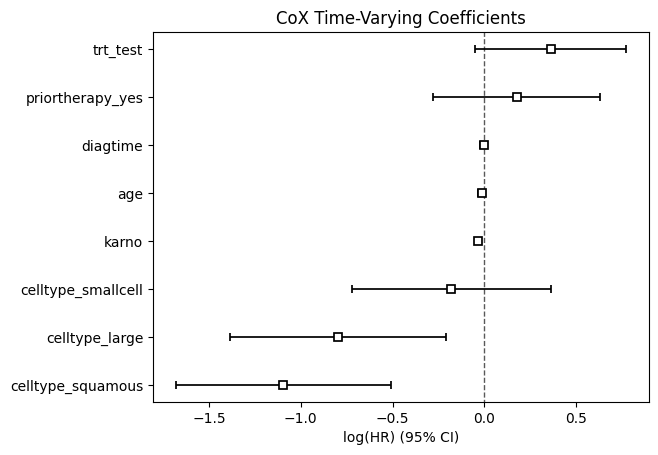

In [55]:
# Ensure 'Y' is not in the modelling data
if 'Y' in df_timevarying.columns:
    df_timevarying.drop(columns=['Y'], inplace=True)

# TimeVarying cox model
from lifelines import CoxTimeVaryingFitter

# Initialize the cox timevarying model
ctv = CoxTimeVaryingFitter()

# Fit the model
ctv.fit(df_timevarying, id_col='ID', event_col='Event', start_col='Start',stop_col='Stop')
ctv.print_summary()

# Plot
ctv.plot()
plt.title("CoX Time-Varying Coefficients")
plt.show()

* Karnofsky score is a strong protective factor: Healthier patients live longer - clear and significant.
* Squamous and large-cell cancer types are associated with lower risk: Compared to the reference cell type.
* Treatment group (trt test) shows higher risk but not significant:  Needs more data or investigation.
* Age, prior therapy, and diagnosis time are not significant: They don't seem to strongly affect survival in this dataset.

# **Summary**
In this Cox time-varying survival model of 128 lung cancer patients, the Karnofsky score, cell type (squamous and large-cell) were significant predictors of survival.

Patients in the test treatment group had a 44% higher hazard, but this was not statistically significant (p = 0.08).

Age, prior therapy, and time since diagnosis showed no significant effects.

# What the Graph Shows

X-axis (log(HR) or log of Hazard Ratio):
* Measures the effect size of each variable on survival (in log scale).
* Left of 0: Lower risk of death (protective).
* Right of 0: Higher risk of death (harmful).
* The further from 0 → the stronger the effect.

Boxes: Estimated effect (log hazard)
* Each square box is the model's estimate for that variable.

Horizontal lines (error bars): Confidence Intervals (95% CI)
* Show the range of uncertainty around each estimate.
* If the line crosses the vertical line at 0, the effect is not statistically significant.


# **Summary**

"The time varying Cox model showed that Karnofsky performance score and tumor cell types (large and squamous) were significantly associated with better survival.

Test treatment showed a higher hazard ratio than standard treatment, but this difference was not statistically significant."

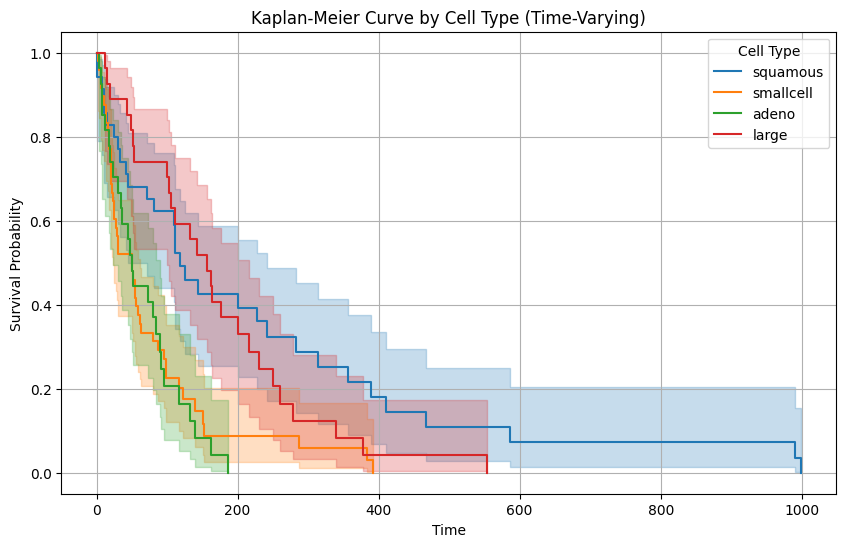

In [56]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))
for cell in df['celltype'].unique():
    mask = df['celltype'] == cell
    kmf.fit(df[mask]['TIME'], event_observed=df[mask]['Y'], label=cell)
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Curve by Cell Type (Time-Varying)')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend(title='Cell Type')
plt.grid(True)
plt.show()

* Each step down in the line means one or more patients died at that time.
* A steep drop means many deaths happened quickly.
* A flatter section means patients survived longer during that time.

**What this Graph shows?**

* Both lines drop quickly at the beginning means most patients die in the first few hundred days.
* Test group has slightly higher survival early on, suggests a possible short-term benefits.
* Standard group drops more quickly after ~200 days could mean higher risk in that group.
* Test group flattens after ~600 days means a few long-term survivors in test group.
* Both groups reach near 0% survival by the end shows very few patients live beyond ~600-1000 days.

**Confidence Intervals (Shaded Areas)**

* The shaded regions around each line represent uncertainty - the wider the shaded area, the less confidence we have in the estimate.
* Overlap between the bands means there's no clear statistical difference in survival between the groups - visually.

# **Summary**
* This graph shows that most patients died within the first 400-500 days, regardless of treatment.
* The test group may have slightly better long-term survival
* The shaded regions overlap, meaning the difference might not be statistically significant.

**Overall**

> "Kaplan-Meier curves show rapid early decline in survival for both treatment groups. The test treatment appears to have slightly better survival beyond 400 days, but overlapping confidence intervals suggest the difference may not be statistically significant.


# **Log-Rank Test time varying**

In this log-rank test compare the survival distributions between two groups of patients with different cell types — in this case, squamous and small cell lung cancer.

The test checks if there is a statistically significant difference in survival time between the two groups, using their TIME and Y (event) values.

The result helps determine whether one group tends to survive longer than the other, and whether the difference is likely due to chance or is statistically meaningful.


In [57]:
group1 = df[df['celltype'] == 'squamous']
group2 = df[df['celltype'] == 'smallcell']

# Perform log-rank test between the two groups
results = logrank_test(group1['TIME'], group2['TIME'],
                       event_observed_A=group1['Y'], event_observed_B=group2['Y'])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          11.57 <0.005     10.55

# **What is a competing Risk?**

Competing risks refer to different possible reasons why a patient might not survive — for example, a patient may die from lung cancer (primary event) or from another unrelated cause like a heart attack (competing event).
Once one event happens, the other events cannot happen.

So, Competing risks are alternative events that prevent the event of interest from occurring. Ignoring them can lead to misleading survival analysis results, especially when other risks are common.

# **Fine-Gray Model**

Fine-Gray model is used to analyze survival data when there are competing risks, meaning multiple possible reasons for death. For example, if the goal is to study death from lung cancer, deaths from other causes (like heart attacks) are competing events.

The Fine-Gray model focuses on estimating the cumulative incidence — the probability over time that a patient experiences the specific event of interest, while properly accounting for the risk of other competing events.





# **Conclusion:**
The "test" treatment did not show a statistically significant improvement in survival compared to the standard treatment.

---

# **Interpretation:**
While the test treatment might look slightly better in survival curves later on, the statistical tests (Log-Rank and Cox models) show that this difference is likely just due to chance and not a real benefit. This suggests the new test treatment isn't significantly better than the existing standard treatment for these patients.

---

# **Learnings:**
This project taught us how to analyze "time-to-event" data, using methods like Kaplan-Meier curves to visualize survival, the Log-Rank test to see if groups have different survival times, and Cox models to understand which factors (like health or treatment) influence survival risk. It highlighted the importance of statistical testing to confirm if visual differences are real or random. We also saw how to handle complex data with time-varying effects.